# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/vit_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [5]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
      201547  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
      201548  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
      201549  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
      201550  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   

                     6         7      8         9  ...       759      760  \
41001 201546 -0.093779  0.015505  0.614 -0.552001  ... -0.805507  0.21285   
      201547 -0.093779  0.015505  0.614 -0.552001  ... -0.805507  0.21285   
      201548 -0.093779  0.015505  0.614 -0.552001  ... -0.805507  0.21285   
      201549 -0.093779  0.015505  0.614 -0.552001  ... -0.805507  0.21285   
      201550 -0.093779  0.015505  0.614 -0.552001  ... -0.805507  0.21285   

                   761       762       763       764       765       766  \
41001 201546  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
      201547  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
      201548  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
      201549  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
      201550  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   

                   767    Labels  
41001 201546  0.014199 -0.861740  
      201547  0.014199 -0.854589  
      201548  0.014199 -0.856973  
      201549  0.014199 -0.856973  
      201550  0.014199 -0.823600  

[5 rows x 769 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0         1         2         3         4         5  \
5360 201546  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
     201547 -0.320510  0.119825  0.137270  0.216795 -0.476022  0.158546   
     201548  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
     201549 -0.444779  0.071139  0.012459 -0.366217 -0.225480 -0.081610   
     201550  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   

                    6         7         8         9  ...       759       760  \
5360 201546 -0.093779  0.015505  0.614000 -0.552001  ... -0.805507  0.212850   
     201547 -0.570430 -0.044212  0.344147 -0.219893  ... -0.319999  0.582625   
     201548 -0.093779  0.015505  0.614000 -0.552001  ... -0.805507  0.212850   
     201549 -0.170546 -0.254429  0.199990 -0.249487  ...  0.342236  0.245481   
     201550 -0.093779  0.015505  0.614000 -0.552001  ... -0.805507  0.212850   

                  761       762       763       764       765       766  \
5360 201546  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
     201547  0.144274 -0.023346  0.200789 -0.030519  0.321033 -0.225532   
     201548  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
     201549  0.160376 -0.515343  0.231088  0.428935  0.251430 -0.283586   
     201550  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   

                  767    Labels  
5360 201546  0.014199 -0.990465  
     201547  0.463084 -0.969011  
     201548  0.014199 -0.995232  
     201549  0.161517 -0.997616  
     201550  0.014199 -0.971395  

[5 rows x 769 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 769)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 768)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 768)
The shape of the labels is (326, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

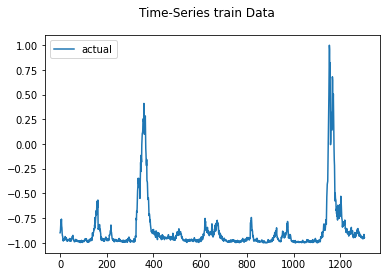

2023-03-06 16:29:20.565916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 16:29:20.565970: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 16:29:20.566001: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-06 16:29:20.566297: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 16:29:20.671500: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 51.082
Test RMSE: 61.810
Test sMAPE: 136.442
Test R Squared: -2.516
{'mae': 51.082045022146836, 'rmse': 61.80983124951418, 'smape': 136.44233880675986, 'r2': -2.51642640083622}


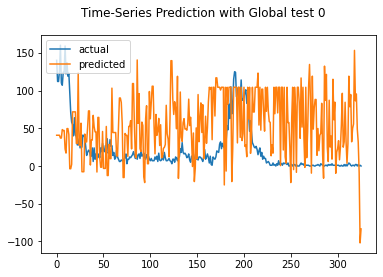

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 53.609
Test RMSE: 66.114
Test sMAPE: 136.877
Test R Squared: -3.023
{'mae': 53.60903386159177, 'rmse': 66.11386192419741, 'smape': 136.87713278593526, 'r2': -3.02319857792763}


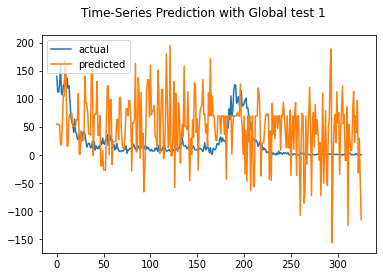

Test MAE: 69.306
Test RMSE: 84.675
Test sMAPE: 141.695
Test R Squared: -5.599
{'mae': 69.30645159417135, 'rmse': 84.6745646256537, 'smape': 141.6951591129764, 'r2': -5.599216262037607}


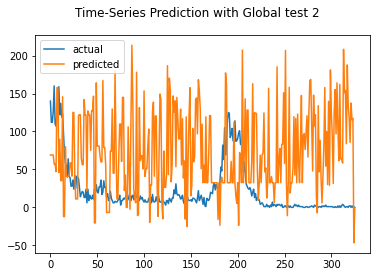

Test MAE: 73.049
Test RMSE: 83.150
Test sMAPE: 150.729
Test R Squared: -5.364
{'mae': 73.04934181245558, 'rmse': 83.15003279217007, 'smape': 150.72914415761585, 'r2': -5.363722977256988}


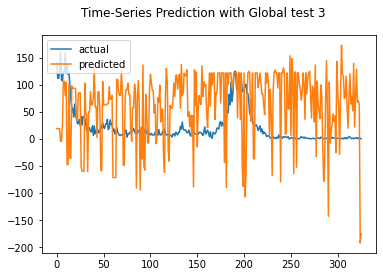

Test MAE: 81.356
Test RMSE: 113.661
Test sMAPE: 151.926
Test R Squared: -10.891
{'mae': 81.35606411465106, 'rmse': 113.66062786307988, 'smape': 151.92576762116275, 'r2': -10.890675239694232}


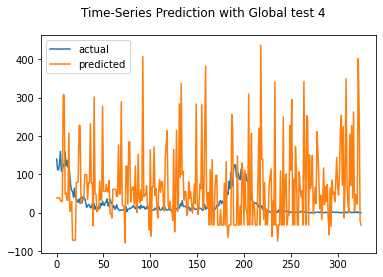

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 56.347
Test RMSE: 67.507
Test sMAPE: 146.704
Test R Squared: -3.195
{'mae': 56.34688332146662, 'rmse': 67.50737843477745, 'smape': 146.7042319192636, 'r2': -3.1945840613057666}


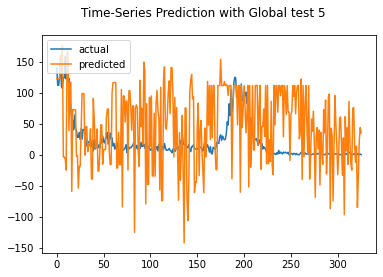

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 59.321
Test RMSE: 69.686
Test sMAPE: 133.526
Test R Squared: -3.470
{'mae': 59.32056290130674, 'rmse': 69.6859378108288, 'smape': 133.52591231436776, 'r2': -3.469682908988381}


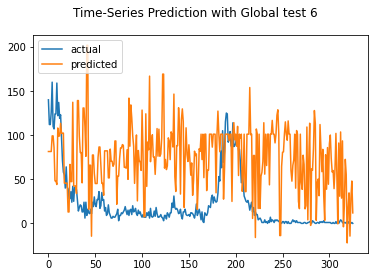

Test MAE: 122.966
Test RMSE: 147.796
Test sMAPE: 163.646
Test R Squared: -19.105
{'mae': 122.96576522171863, 'rmse': 147.79581694901228, 'smape': 163.64649099978178, 'r2': -19.10530663404438}


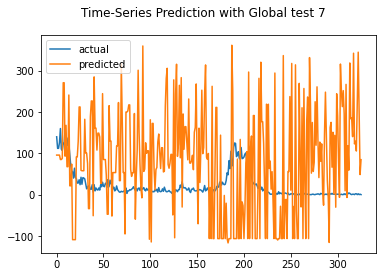

Test MAE: 68.795
Test RMSE: 79.690
Test sMAPE: 150.226
Test R Squared: -4.845
{'mae': 68.79548365718748, 'rmse': 79.689797825732, 'smape': 150.22609472172306, 'r2': -4.845098931644085}


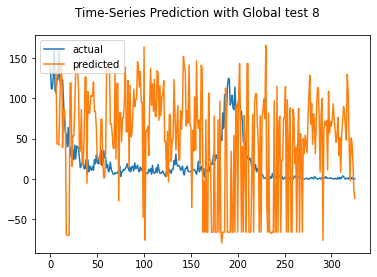

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 62.854
Test RMSE: 73.710
Test sMAPE: 141.987
Test R Squared: -4.001
{'mae': 62.853956913472686, 'rmse': 73.71017623719925, 'smape': 141.9869868599739, 'r2': -4.000821065983382}


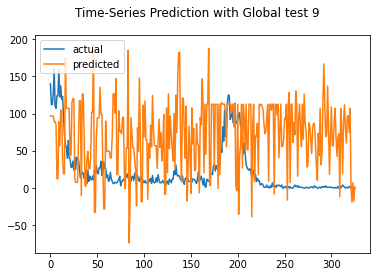

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 65.909
Test RMSE: 80.619
Test sMAPE: 150.859
Test R Squared: -4.982
{'mae': 65.9093935145008, 'rmse': 80.6194584321941, 'smape': 150.85903283793544, 'r2': -4.982272186575805}


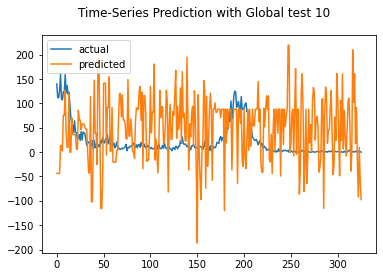

Test MAE: 56.594
Test RMSE: 67.248
Test sMAPE: 136.104
Test R Squared: -3.162
{'mae': 56.59400410154846, 'rmse': 67.2481303735406, 'smape': 136.10360335179706, 'r2': -3.1624290651761244}


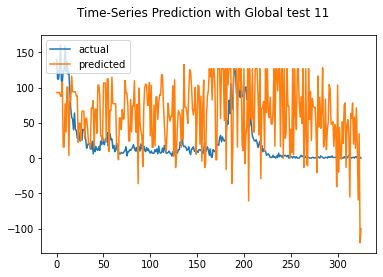

Test MAE: 130.303
Test RMSE: 157.002
Test sMAPE: 173.271
Test R Squared: -21.688
{'mae': 130.30258230928993, 'rmse': 157.00199716823542, 'smape': 173.27138642099789, 'r2': -21.688029078406615}


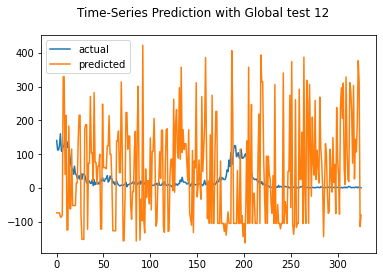

Test MAE: 45.540
Test RMSE: 57.586
Test sMAPE: 129.716
Test R Squared: -2.052
{'mae': 45.53999708693452, 'rmse': 57.58602203974267, 'smape': 129.71591690652343, 'r2': -2.0522533176145767}


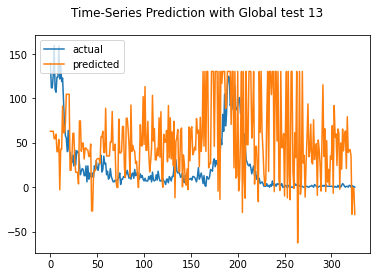

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 52.510
Test RMSE: 64.122
Test sMAPE: 137.520
Test R Squared: -2.784
{'mae': 52.51038521345408, 'rmse': 64.12165734759645, 'smape': 137.5203617008419, 'r2': -2.784390069730466}


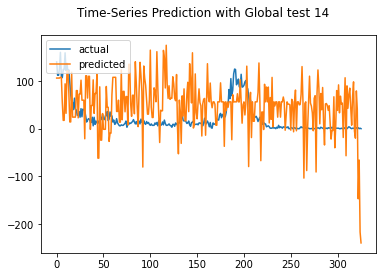

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 49.107
Test RMSE: 59.681
Test sMAPE: 148.370
Test R Squared: -2.278
{'mae': 49.10687800821351, 'rmse': 59.681445789205284, 'smape': 148.36951710154722, 'r2': -2.278423748578407}


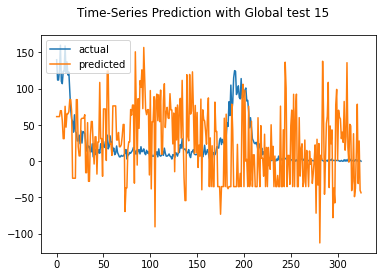

Test MAE: 58.685
Test RMSE: 69.577
Test sMAPE: 141.297
Test R Squared: -3.456
{'mae': 58.68525079075544, 'rmse': 69.57683575535303, 'smape': 141.29748880051054, 'r2': -3.4556981692199624}


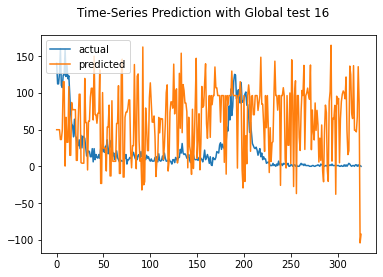

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 53.385
Test RMSE: 65.537
Test sMAPE: 138.465
Test R Squared: -2.953
{'mae': 53.385279687178645, 'rmse': 65.53654109590533, 'smape': 138.4649350178446, 'r2': -2.95324243841333}


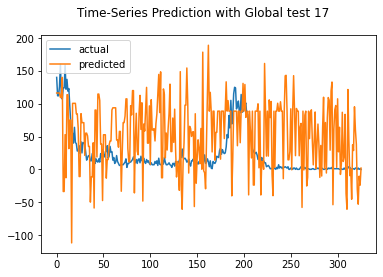

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 49.372
Test RMSE: 61.775
Test sMAPE: 134.836
Test R Squared: -2.512
{'mae': 49.37151604031492, 'rmse': 61.775051743269735, 'smape': 134.83567139442692, 'r2': -2.5124702287067846}


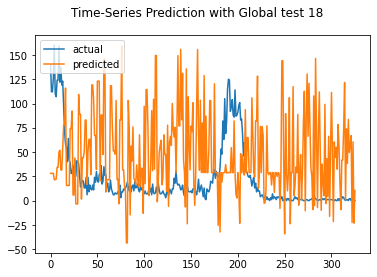

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 55.732
Test RMSE: 65.611
Test sMAPE: 134.896
Test R Squared: -2.962
{'mae': 55.73192201691902, 'rmse': 65.61069297037704, 'smape': 134.8956221556013, 'r2': -2.9621933586237454}


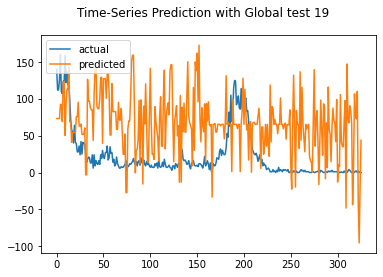

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 47.694
Test RMSE: 58.271
Test sMAPE: 135.981
Test R Squared: -2.125
{'mae': 47.69444798563887, 'rmse': 58.27082790555094, 'smape': 135.9811846939766, 'r2': -2.1252789966719545}


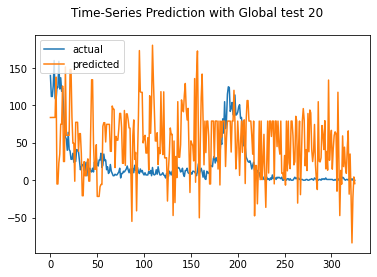

Test MAE: 70.314
Test RMSE: 80.124
Test sMAPE: 152.720
Test R Squared: -4.909
{'mae': 70.31362673914505, 'rmse': 80.12389424230781, 'smape': 152.71995623719005, 'r2': -4.908952710206848}


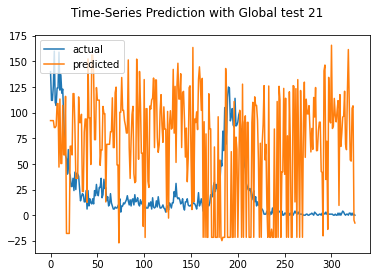

Test MAE: 95.665
Test RMSE: 129.294
Test sMAPE: 158.398
Test R Squared: -14.387
{'mae': 95.66490024108828, 'rmse': 129.29372860325492, 'smape': 158.39750078608253, 'r2': -14.38655296197454}


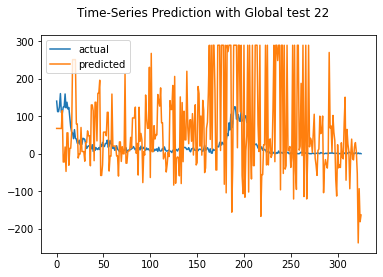

Test MAE: 55.921
Test RMSE: 67.494
Test sMAPE: 131.999
Test R Squared: -3.193
{'mae': 55.92085059471657, 'rmse': 67.49447677687931, 'smape': 131.9992570665297, 'r2': -3.1929809204772868}


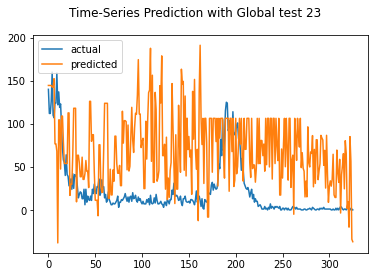

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 46.702
Test RMSE: 57.450
Test sMAPE: 131.470
Test R Squared: -2.038
{'mae': 46.701885372948794, 'rmse': 57.45044226517907, 'smape': 131.47018743358709, 'r2': -2.037897866364748}


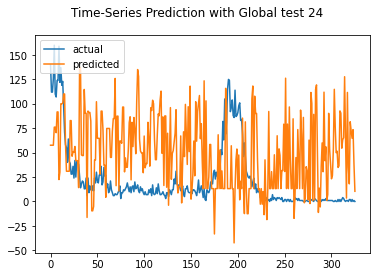

Test MAE: 78.370
Test RMSE: 93.058
Test sMAPE: 161.896
Test R Squared: -6.971
{'mae': 78.36959151859664, 'rmse': 93.05758541539205, 'smape': 161.89568571585224, 'r2': -6.970580923638212}


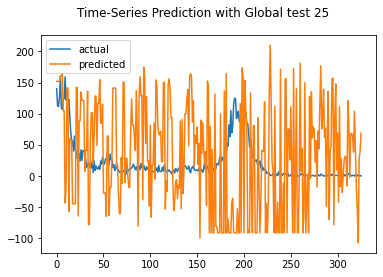

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 55.045
Test RMSE: 67.581
Test sMAPE: 141.711
Test R Squared: -3.204
{'mae': 55.044539010232214, 'rmse': 67.58062631823921, 'smape': 141.7111368185246, 'r2': -3.2036915425062302}


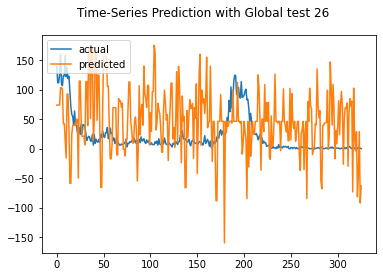

Test MAE: 55.674
Test RMSE: 66.870
Test sMAPE: 143.628
Test R Squared: -3.116
{'mae': 55.67408421754472, 'rmse': 66.8704447677317, 'smape': 143.62796025859177, 'r2': -3.115805467703198}


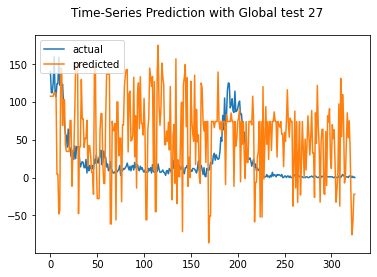

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 54.108
Test RMSE: 66.954
Test sMAPE: 134.190
Test R Squared: -3.126
{'mae': 54.1084007593386, 'rmse': 66.95445761680539, 'smape': 134.19035381955115, 'r2': -3.1261537689863195}


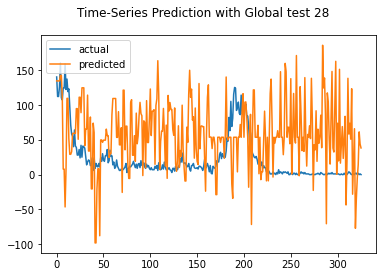

Test MAE: 122.393
Test RMSE: 159.677
Test sMAPE: 165.391
Test R Squared: -22.468
{'mae': 122.39333307194563, 'rmse': 159.67653942627442, 'smape': 165.39142144975546, 'r2': -22.467597986720005}


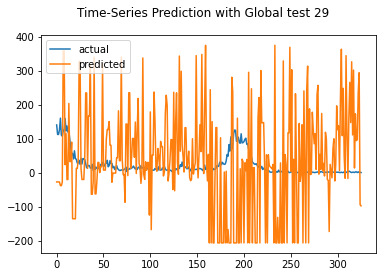

Test MAE: 63.699
Test RMSE: 90.234
Test sMAPE: 136.947
Test R Squared: -6.494
{'mae': 63.69864521070492, 'rmse': 90.23353021770305, 'smape': 136.9471805294866, 'r2': -6.4941488268290595}


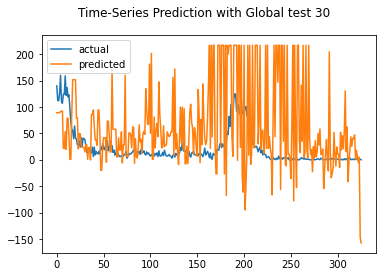

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 57.836
Test RMSE: 69.093
Test sMAPE: 135.484
Test R Squared: -3.394
{'mae': 57.8360688858237, 'rmse': 69.09285446403551, 'smape': 135.48423263537717, 'r2': -3.393925476135874}


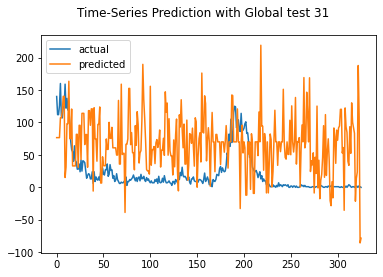

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 57.830
Test RMSE: 72.847
Test sMAPE: 142.968
Test R Squared: -3.884
{'mae': 57.829884473165855, 'rmse': 72.84674924411586, 'smape': 142.9675098503776, 'r2': -3.8843499106079964}


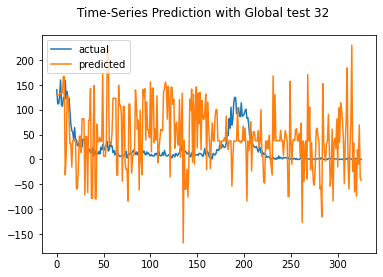

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 53.520
Test RMSE: 70.448
Test sMAPE: 139.344
Test R Squared: -3.568
{'mae': 53.51985905388016, 'rmse': 70.44835459667995, 'smape': 139.3438636387455, 'r2': -3.5680213435657606}


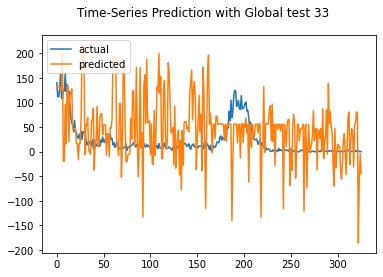

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 54.843
Test RMSE: 66.967
Test sMAPE: 132.979
Test R Squared: -3.128
{'mae': 54.84282289216855, 'rmse': 66.96693521667879, 'smape': 132.97876482576368, 'r2': -3.12769180827126}


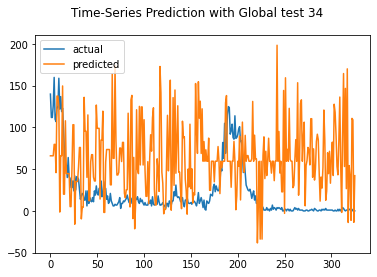

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 48.487
Test RMSE: 61.011
Test sMAPE: 137.145
Test R Squared: -2.426
{'mae': 48.48692641558091, 'rmse': 61.01128085890611, 'smape': 137.14523252812793, 'r2': -2.4261525916843922}


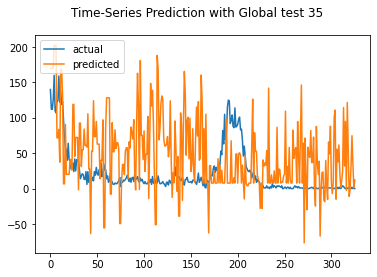

Test MAE: 86.626
Test RMSE: 101.147
Test sMAPE: 158.239
Test R Squared: -8.417
{'mae': 86.62614765781566, 'rmse': 101.14703100432011, 'smape': 158.2392498370638, 'r2': -8.41656903967785}


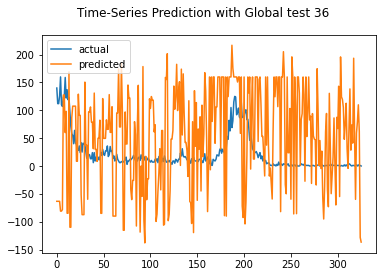

Test MAE: 90.950
Test RMSE: 116.185
Test sMAPE: 150.618
Test R Squared: -11.425
{'mae': 90.95032192775808, 'rmse': 116.18492685902432, 'smape': 150.61848865726816, 'r2': -11.424702368030704}


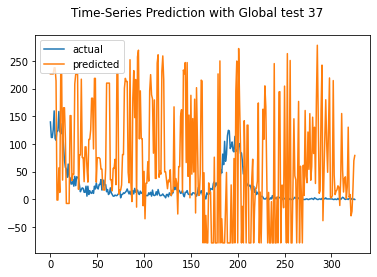

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 50.062
Test RMSE: 59.619
Test sMAPE: 135.135
Test R Squared: -2.272
{'mae': 50.06152935152405, 'rmse': 59.61871313339146, 'smape': 135.13477275452834, 'r2': -2.271535304891637}


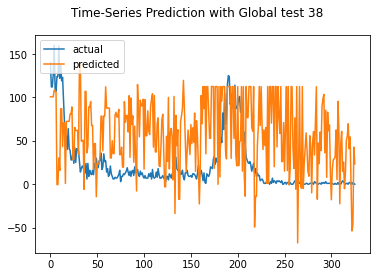

Test MAE: 48.374
Test RMSE: 57.437
Test sMAPE: 134.726
Test R Squared: -2.036
{'mae': 48.374388523079865, 'rmse': 57.436969287302844, 'smape': 134.72633466727396, 'r2': -2.036473169535961}


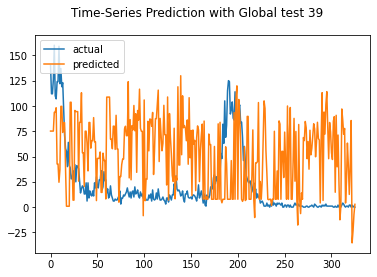

Test MAE: 40.621
Test RMSE: 51.586
Test sMAPE: 127.052
Test R Squared: -1.449
{'mae': 40.620586101262845, 'rmse': 51.58587753060715, 'smape': 127.05174154906803, 'r2': -1.4493342853409135}


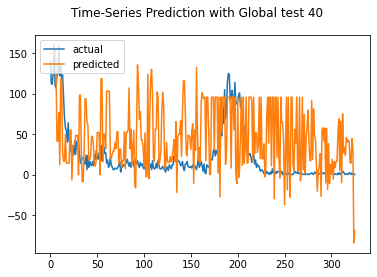

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 38.843
Test RMSE: 49.998
Test sMAPE: 134.308
Test R Squared: -1.301
{'mae': 38.84286825569129, 'rmse': 49.9981923667237, 'smape': 134.30807676509693, 'r2': -1.3008855810411126}


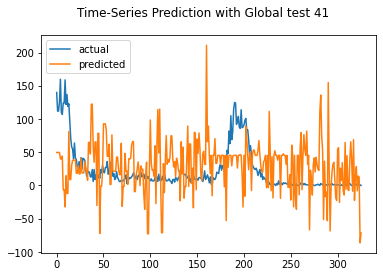

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 55.160
Test RMSE: 69.053
Test sMAPE: 145.850
Test R Squared: -3.389
{'mae': 55.159976971661386, 'rmse': 69.05288547722809, 'smape': 145.8499212064803, 'r2': -3.388843331129383}


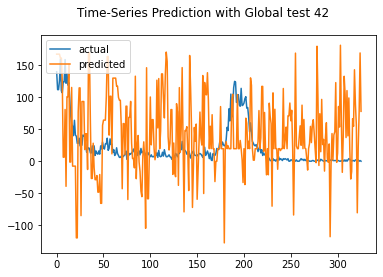

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 55.075
Test RMSE: 68.340
Test sMAPE: 134.990
Test R Squared: -3.299
{'mae': 55.07485090552664, 'rmse': 68.33972813251131, 'smape': 134.9895348698112, 'r2': -3.298658154397039}


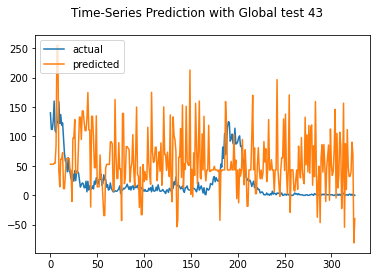

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 58.055
Test RMSE: 69.534
Test sMAPE: 138.884
Test R Squared: -3.450
{'mae': 58.05469597446407, 'rmse': 69.53403617096119, 'smape': 138.8839037000379, 'r2': -3.4502180874254327}


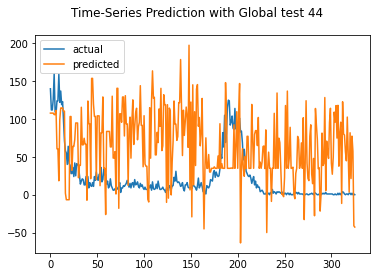

Test MAE: 84.623
Test RMSE: 99.543
Test sMAPE: 155.110
Test R Squared: -8.120
{'mae': 84.62285665354115, 'rmse': 99.54340451559654, 'smape': 155.11019446769512, 'r2': -8.120347719622242}


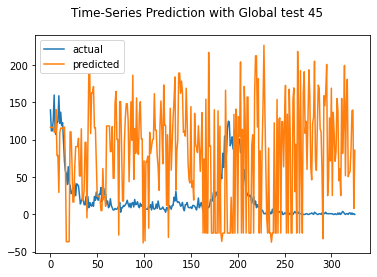

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 39.210
Test RMSE: 49.979
Test sMAPE: 127.470
Test R Squared: -1.299
{'mae': 39.210153399252455, 'rmse': 49.978664595141574, 'smape': 127.47015554501452, 'r2': -1.2990886203285887}


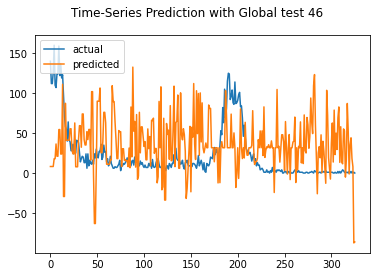

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 53.157
Test RMSE: 65.170
Test sMAPE: 134.762
Test R Squared: -2.909
{'mae': 53.156792183412364, 'rmse': 65.16988847065967, 'smape': 134.76174313930989, 'r2': -2.9091323257974318}


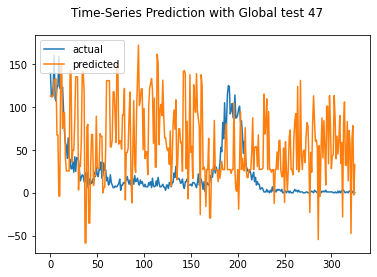

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 48.513
Test RMSE: 56.070
Test sMAPE: 134.230
Test R Squared: -1.894
{'mae': 48.51268756755291, 'rmse': 56.06985623058037, 'smape': 134.22973051595775, 'r2': -1.893645343767827}


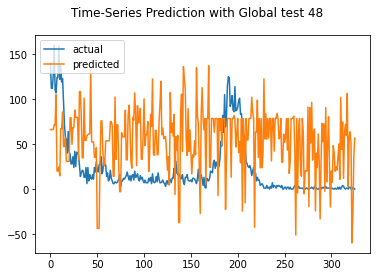

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 52.433
Test RMSE: 62.224
Test sMAPE: 137.707
Test R Squared: -2.564
{'mae': 52.43331003006251, 'rmse': 62.22355403740915, 'smape': 137.70705667489383, 'r2': -2.563658196393409}


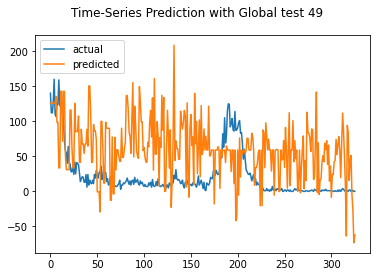

Test MAE: 65.830
Test RMSE: 83.866
Test sMAPE: 144.121
Test R Squared: -5.474
{'mae': 65.82970415119745, 'rmse': 83.86551900644433, 'smape': 144.1214826754903, 'r2': -5.473710798536027}


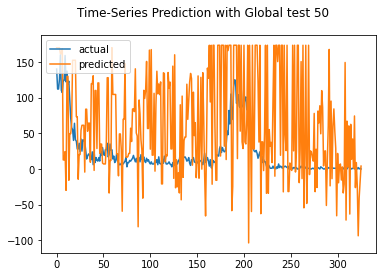

Test MAE: 99.245
Test RMSE: 115.737
Test sMAPE: 160.024
Test R Squared: -11.329
{'mae': 99.24459509560667, 'rmse': 115.73703483516935, 'smape': 160.02406886380328, 'r2': -11.329092741768974}


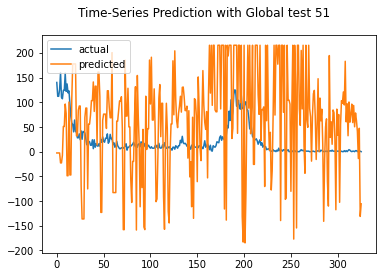

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 58.363
Test RMSE: 69.124
Test sMAPE: 141.670
Test R Squared: -3.398
{'mae': 58.363028701554775, 'rmse': 69.12395330686395, 'smape': 141.67029473513966, 'r2': -3.397881796978938}


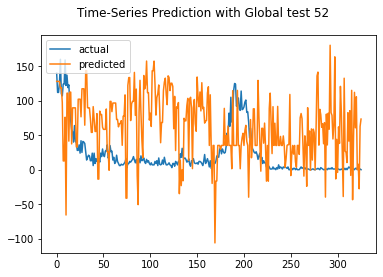

Test MAE: 77.896
Test RMSE: 94.290
Test sMAPE: 155.809
Test R Squared: -7.183
{'mae': 77.89579557458316, 'rmse': 94.28980918014953, 'smape': 155.80920133084715, 'r2': -7.183063661869419}


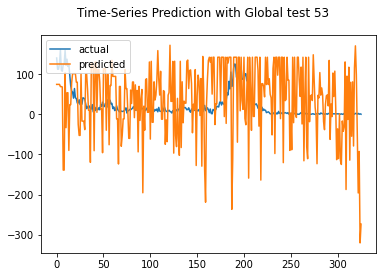

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 50.965
Test RMSE: 62.017
Test sMAPE: 131.561
Test R Squared: -2.540
{'mae': 50.965246311086084, 'rmse': 62.01712032933732, 'smape': 131.5610479813435, 'r2': -2.540051738334024}


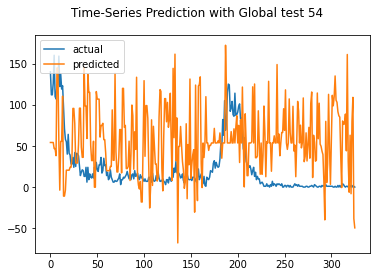

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 64.608
Test RMSE: 77.025
Test sMAPE: 143.123
Test R Squared: -4.461
{'mae': 64.60772952656805, 'rmse': 77.0250126053935, 'smape': 143.1234097127368, 'r2': -4.460720802301465}


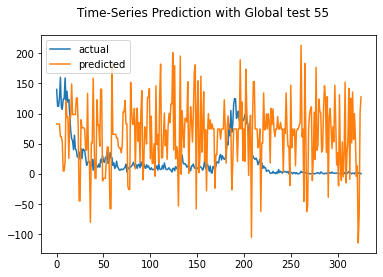

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 50.613
Test RMSE: 65.024
Test sMAPE: 140.877
Test R Squared: -2.892
{'mae': 50.613099927551175, 'rmse': 65.02442820999471, 'smape': 140.87728865266212, 'r2': -2.8917013056737297}


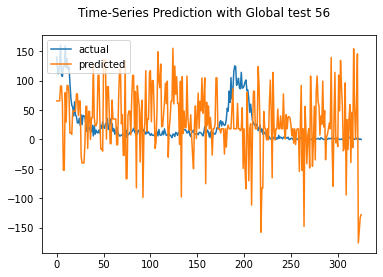

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 51.672
Test RMSE: 65.310
Test sMAPE: 148.904
Test R Squared: -2.926
{'mae': 51.672273332173106, 'rmse': 65.30957527345848, 'smape': 148.90383694556655, 'r2': -2.925908153480705}


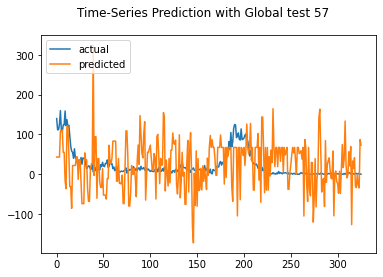

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 52.869
Test RMSE: 65.151
Test sMAPE: 132.042
Test R Squared: -2.907
{'mae': 52.86872097831562, 'rmse': 65.15051307120031, 'smape': 132.04239298341713, 'r2': -2.9068082542668003}


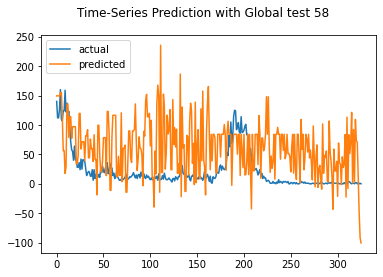

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 55.552
Test RMSE: 72.287
Test sMAPE: 145.602
Test R Squared: -3.810
{'mae': 55.55218654743002, 'rmse': 72.28674415904801, 'smape': 145.60177160379214, 'r2': -3.809542256524951}


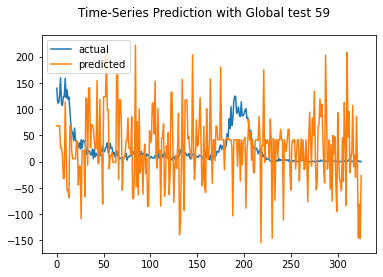

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 49.506
Test RMSE: 62.450
Test sMAPE: 135.929
Test R Squared: -2.590
{'mae': 49.50595423725485, 'rmse': 62.450116088736365, 'smape': 135.92892314999395, 'r2': -2.589656698607045}


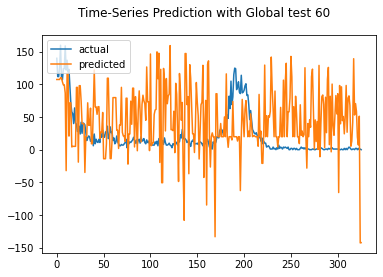

Test MAE: 88.180
Test RMSE: 111.847
Test sMAPE: 152.536
Test R Squared: -10.514
{'mae': 88.1796320552475, 'rmse': 111.84659103080631, 'smape': 152.5355498047605, 'r2': -10.514150977708715}


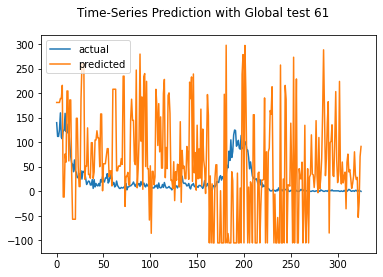

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 47.970
Test RMSE: 59.161
Test sMAPE: 134.441
Test R Squared: -2.221
{'mae': 47.97019848849144, 'rmse': 59.16082322288074, 'smape': 134.44066021750666, 'r2': -2.2214755042203365}


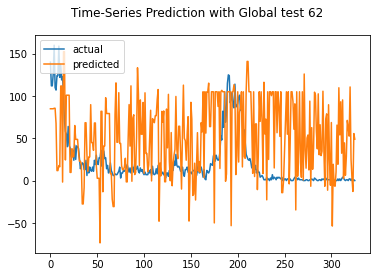

Test MAE: 62.029
Test RMSE: 81.941
Test sMAPE: 133.471
Test R Squared: -5.180
{'mae': 62.02891038824444, 'rmse': 81.94141108231757, 'smape': 133.4713123393475, 'r2': -5.1800685622870635}


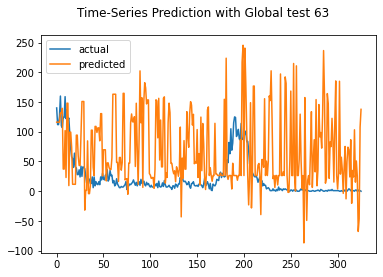

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 52.610
Test RMSE: 65.075
Test sMAPE: 132.768
Test R Squared: -2.898
{'mae': 52.610042863279766, 'rmse': 65.07489993892402, 'smape': 132.76810673008796, 'r2': -2.897745099656421}


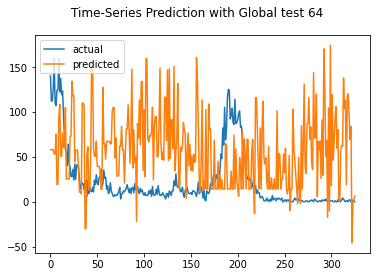

Test MAE: 59.971
Test RMSE: 69.399
Test sMAPE: 135.018
Test R Squared: -3.433
{'mae': 59.97109352299041, 'rmse': 69.39851845289479, 'smape': 135.0179037112456, 'r2': -3.432888568059954}


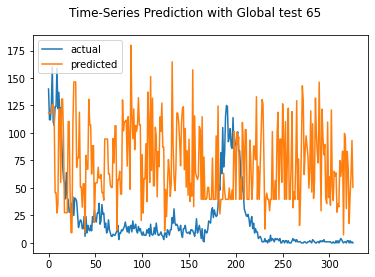

Test MAE: 85.074
Test RMSE: 102.408
Test sMAPE: 157.637
Test R Squared: -8.653
{'mae': 85.07398160249909, 'rmse': 102.40776600624449, 'smape': 157.63667813772113, 'r2': -8.652775389345639}


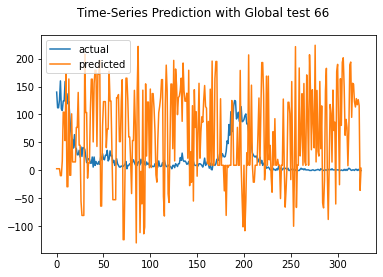

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 47.731
Test RMSE: 55.766
Test sMAPE: 137.005
Test R Squared: -1.862
{'mae': 47.73095405284612, 'rmse': 55.76626524108725, 'smape': 137.00523667451804, 'r2': -1.8623948134979376}


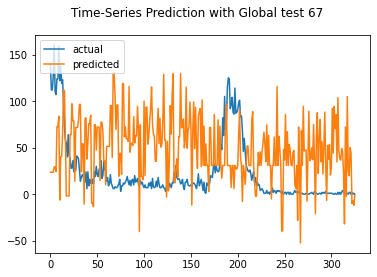

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 49.061
Test RMSE: 60.055
Test sMAPE: 133.667
Test R Squared: -2.320
{'mae': 49.061406895975395, 'rmse': 60.05464597737864, 'smape': 133.66689258865756, 'r2': -2.319553240890338}


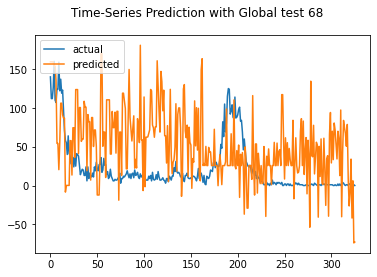

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 50.815
Test RMSE: 60.590
Test sMAPE: 132.756
Test R Squared: -2.379
{'mae': 50.815424051387176, 'rmse': 60.59039057765159, 'smape': 132.75573023882095, 'r2': -2.37904457087259}


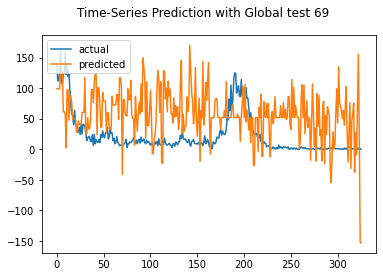

Test MAE: 51.360
Test RMSE: 60.013
Test sMAPE: 131.898
Test R Squared: -2.315
{'mae': 51.360104045802096, 'rmse': 60.01314666596509, 'smape': 131.8977421768618, 'r2': -2.314967031984003}


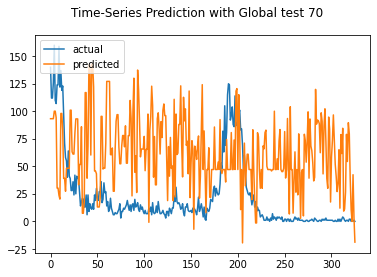

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 46.930
Test RMSE: 59.414
Test sMAPE: 132.377
Test R Squared: -2.249
{'mae': 46.930262510030545, 'rmse': 59.413798099810435, 'smape': 132.3766181224936, 'r2': -2.2490848143991093}


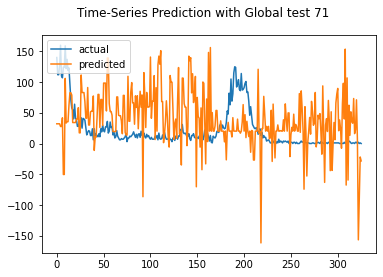

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 50.672
Test RMSE: 60.496
Test sMAPE: 131.329
Test R Squared: -2.368
{'mae': 50.672319636205955, 'rmse': 60.49566425402219, 'smape': 131.32930192839416, 'r2': -2.368487310609699}


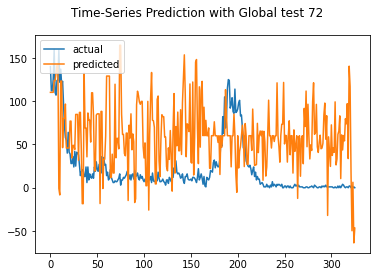

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 56.977
Test RMSE: 72.491
Test sMAPE: 149.135
Test R Squared: -3.837
{'mae': 56.97681287314994, 'rmse': 72.49089059156007, 'smape': 149.13493816044175, 'r2': -3.8367460637359905}


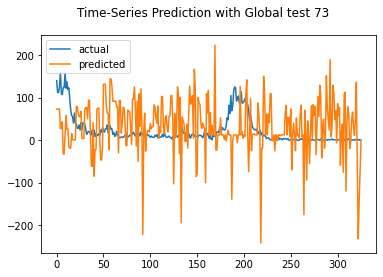

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 54.409
Test RMSE: 65.294
Test sMAPE: 140.881
Test R Squared: -2.924
{'mae': 54.40894937515259, 'rmse': 65.29415884554462, 'smape': 140.88123905309277, 'r2': -2.924054938650877}


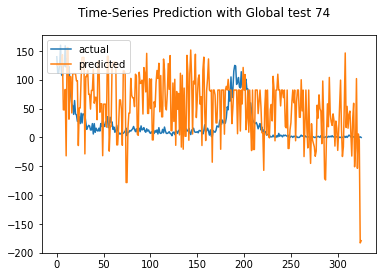

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 57.985
Test RMSE: 71.795
Test sMAPE: 138.304
Test R Squared: -3.744
{'mae': 57.98547663032277, 'rmse': 71.79451237734209, 'smape': 138.30374620038043, 'r2': -3.7442647503229107}


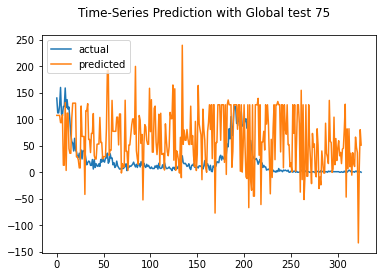

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 56.449
Test RMSE: 69.830
Test sMAPE: 137.282
Test R Squared: -3.488
{'mae': 56.449266616917825, 'rmse': 69.83020709889622, 'smape': 137.28230441533083, 'r2': -3.4882090417632137}


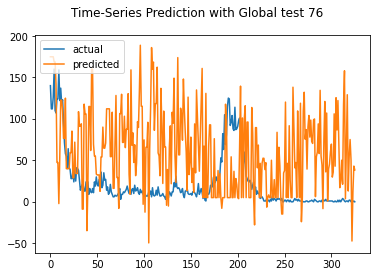

Test MAE: 56.683
Test RMSE: 65.651
Test sMAPE: 135.319
Test R Squared: -2.967
{'mae': 56.682904274917085, 'rmse': 65.65135489825036, 'smape': 135.31927814091998, 'r2': -2.9671059829840947}


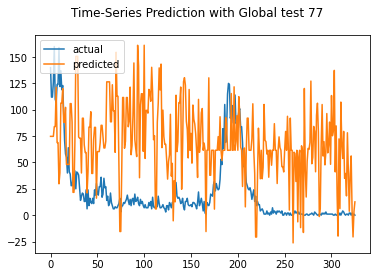

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 51.428
Test RMSE: 61.444
Test sMAPE: 131.113
Test R Squared: -2.475
{'mae': 51.42825277670761, 'rmse': 61.44378743848656, 'smape': 131.11271219218585, 'r2': -2.4749004903537317}


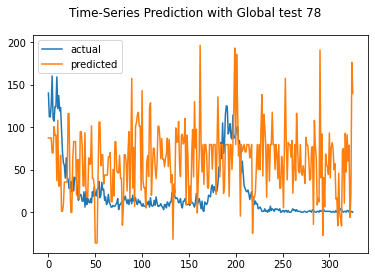

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 48.838
Test RMSE: 57.298
Test sMAPE: 131.805
Test R Squared: -2.022
{'mae': 48.83832560872739, 'rmse': 57.29758122677138, 'smape': 131.80540961619718, 'r2': -2.021753223763589}


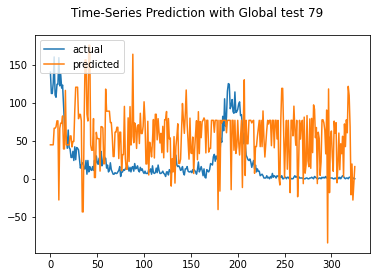

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 57.290
Test RMSE: 73.171
Test sMAPE: 159.307
Test R Squared: -3.928
{'mae': 57.28997803429153, 'rmse': 73.17111652048173, 'smape': 159.30723765339545, 'r2': -3.9279441843325316}


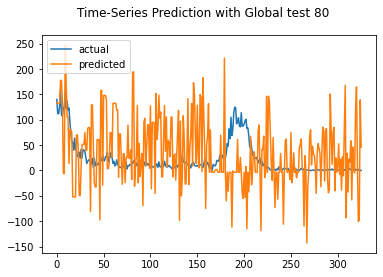

Test MAE: 66.085
Test RMSE: 75.133
Test sMAPE: 148.702
Test R Squared: -4.196
{'mae': 66.08539846886886, 'rmse': 75.13288787807795, 'smape': 148.7022033331471, 'r2': -4.19573007039683}


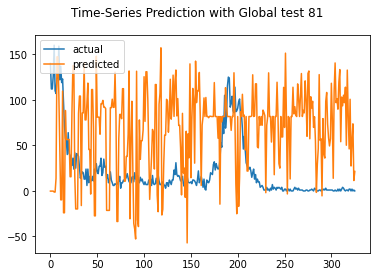

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 56.375
Test RMSE: 66.457
Test sMAPE: 138.200
Test R Squared: -3.065
{'mae': 56.375484885247936, 'rmse': 66.45655512254545, 'smape': 138.2003281695841, 'r2': -3.0650141962971684}


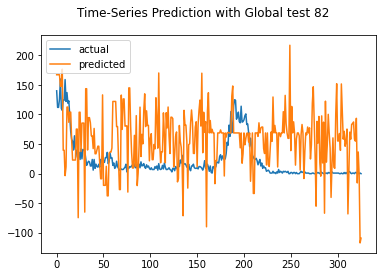

Test MAE: 44.239
Test RMSE: 54.864
Test sMAPE: 131.241
Test R Squared: -1.771
{'mae': 44.23893929844254, 'rmse': 54.864097681688854, 'smape': 131.24128422180897, 'r2': -1.7705302618499648}


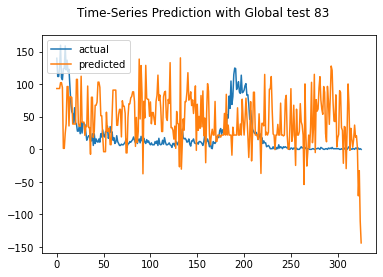

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 46.143
Test RMSE: 55.494
Test sMAPE: 128.950
Test R Squared: -1.834
{'mae': 46.142767591619055, 'rmse': 55.49378303359911, 'smape': 128.94999253618894, 'r2': -1.8344909840185806}


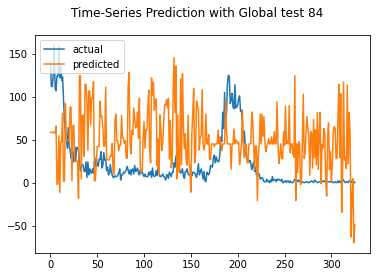

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 46.779
Test RMSE: 55.662
Test sMAPE: 144.144
Test R Squared: -1.852
{'mae': 46.77905048823064, 'rmse': 55.66152901046978, 'smape': 144.14367095862977, 'r2': -1.8516530177603916}


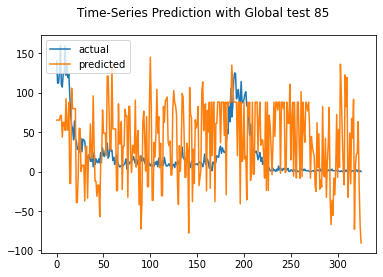

Test MAE: 55.416
Test RMSE: 68.075
Test sMAPE: 134.111
Test R Squared: -3.265
{'mae': 55.41556468496293, 'rmse': 68.0746559966751, 'smape': 134.11061113730642, 'r2': -3.2653760590595438}


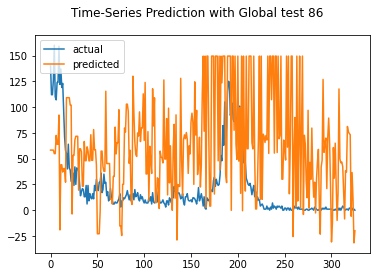

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 56.241
Test RMSE: 66.758
Test sMAPE: 140.545
Test R Squared: -3.102
{'mae': 56.24108578968633, 'rmse': 66.75756214336249, 'smape': 140.54521944091897, 'r2': -3.1019215828008546}


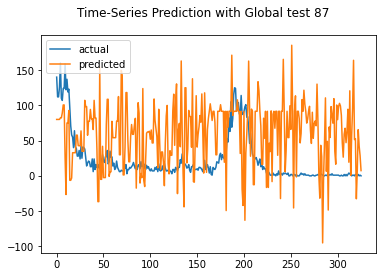

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 57.226
Test RMSE: 65.742
Test sMAPE: 134.874
Test R Squared: -2.978
{'mae': 57.22579259777362, 'rmse': 65.74162922731001, 'smape': 134.87406822744214, 'r2': -2.978023474466096}


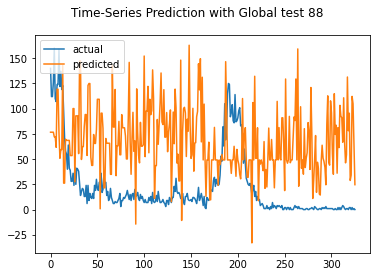

Test MAE: 60.466
Test RMSE: 73.912
Test sMAPE: 135.938
Test R Squared: -4.028
{'mae': 60.466187022946364, 'rmse': 73.91236399503256, 'smape': 135.93811887147493, 'r2': -4.028293298059877}


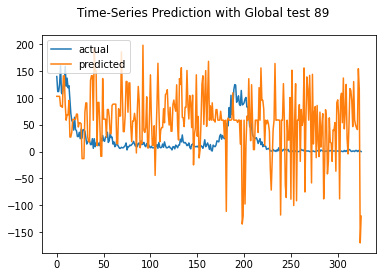

Test MAE: 43.318
Test RMSE: 53.859
Test sMAPE: 129.976
Test R Squared: -1.670
{'mae': 43.317559836832295, 'rmse': 53.85888433178917, 'smape': 129.97646284153953, 'r2': -1.6699376650889945}


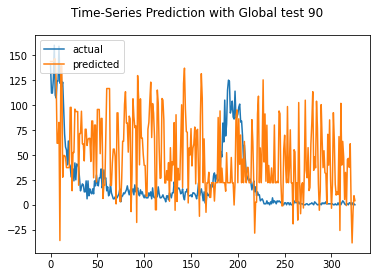

Test MAE: 88.001
Test RMSE: 105.601
Test sMAPE: 152.969
Test R Squared: -9.264
{'mae': 88.00124153330282, 'rmse': 105.60126732978982, 'smape': 152.96946726154582, 'r2': -9.264189858969281}


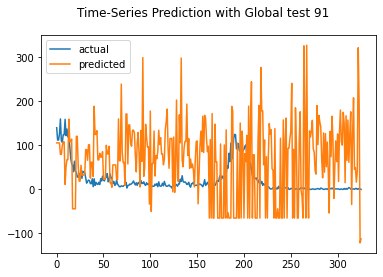

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 54.645
Test RMSE: 64.722
Test sMAPE: 135.705
Test R Squared: -2.856
{'mae': 54.64492618598821, 'rmse': 64.72150227386719, 'smape': 135.70457697548824, 'r2': -2.8555256326314846}


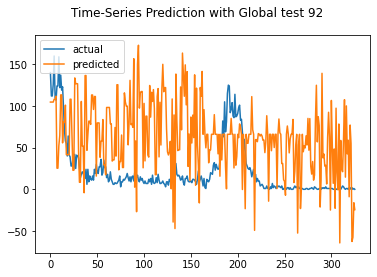

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 55.697
Test RMSE: 68.025
Test sMAPE: 160.503
Test R Squared: -3.259
{'mae': 55.69666377331581, 'rmse': 68.02490264802955, 'smape': 160.50346995195537, 'r2': -3.2591435136805176}


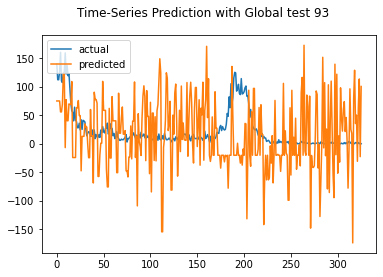

Test MAE: 67.453
Test RMSE: 85.555
Test sMAPE: 150.997
Test R Squared: -5.737
{'mae': 67.45331159362033, 'rmse': 85.55455094472188, 'smape': 150.99668914685094, 'r2': -5.737094644349234}


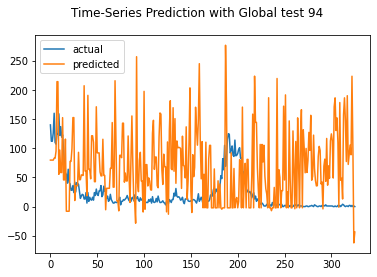

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 38.392
Test RMSE: 48.762
Test sMAPE: 130.855
Test R Squared: -1.189
{'mae': 38.39209821820259, 'rmse': 48.76228182564154, 'smape': 130.85509864935605, 'r2': -1.1885398384890822}


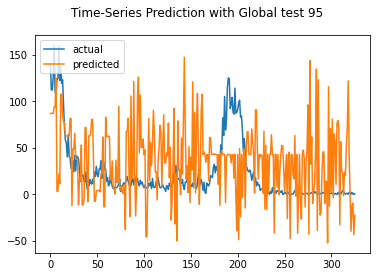

Test MAE: 57.722
Test RMSE: 69.026
Test sMAPE: 135.313
Test R Squared: -3.385
{'mae': 57.72162028763192, 'rmse': 69.02631915092358, 'smape': 135.31291399603575, 'r2': -3.3854669909612527}


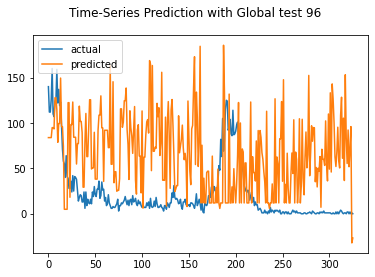

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 53.850
Test RMSE: 66.346
Test sMAPE: 138.032
Test R Squared: -3.052
{'mae': 53.84950921542806, 'rmse': 66.3461067342609, 'smape': 138.03204846659796, 'r2': -3.0515136115611465}


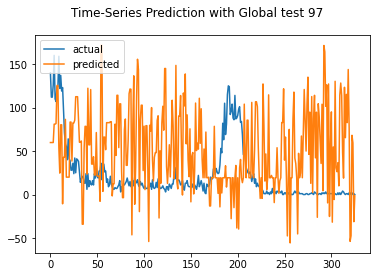

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 56.273
Test RMSE: 70.947
Test sMAPE: 140.822
Test R Squared: -3.633
{'mae': 56.27309999509823, 'rmse': 70.94710199385638, 'smape': 140.8224597985665, 'r2': -3.632929984081196}


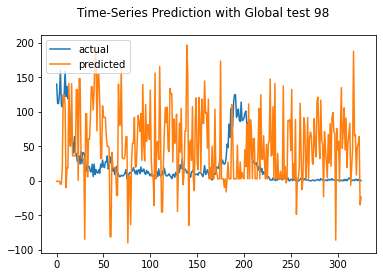

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 39.099
Test RMSE: 49.943
Test sMAPE: 135.750
Test R Squared: -1.296
{'mae': 39.09867533703157, 'rmse': 49.94275520838418, 'smape': 135.74990662268587, 'r2': -1.2957860429552852}


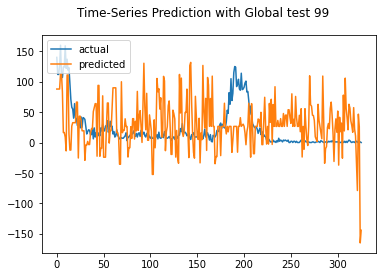

rmse : average=73.301, std=21.173
mae : average=59.886, std=16.885
smape : average=141.058, std=9.677
r2 : average=-4.358, std=3.809


([73.30110406317914, 21.1732499956573],
 [59.88625436625141, 16.885050259828983],
 [141.0576603496888, 9.676515967998148],
 [-4.358099228457453, 3.8089813644703967])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
